In [77]:
#important to have the correct version of sklearn 0.23.1 and correct version of joblib 1.2.0
!pip show joblib

Name: joblib
Version: 1.2.0
Summary: Lightweight pipelining with Python functions
Home-page: https://joblib.readthedocs.io
Author: Gael Varoquaux
Author-email: gael.varoquaux@normalesup.org
License: BSD
Location: /opt/conda/lib/python3.7/site-packages
Requires: 
Required-by: nltk, scikit-learn


In [78]:
!pip show scikit-learn

Name: scikit-learn
Version: 0.23.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /opt/conda/lib/python3.7/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: sagemaker-data-insights, smclarify


In [79]:
!pip install --upgrade scikit-learn==0.23.1

In [80]:
%%html
Steps</br>
#1) Download the movie data sets available in the s3 bucket to the sagemaker notebook environment. </br>
#2) Start analyzing the data

In [2]:
import pandas as pd
import boto3
from sklearn.preprocessing import StandardScaler

import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
bucket_name='awesome2023-545313841491'

title_basic = 'csv_files/title.basics.tsv'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket = bucket_name,Key = title_basic)

df_title_basic = pd.read_table(obj['Body'])
df_title_basic = df_title_basic.dropna()
df_title_basic.head()


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [3]:
print("finding the unique columns in the data set \n")
print(df_title_basic.nunique(axis=0))

print("Explore how many media items are in each title types \n")
print(df_title_basic.groupby('titleType')['tconst'].nunique())

# Cleanup steps - Consider only those titles which are movies
title_basics_processed = df_title_basic[df_title_basic['titleType']=='movie']

# Cleanup steps - We dont need end year for this data set
title_basics_processed = title_basics_processed.drop(columns = "endYear")

#Cleanup steps - We dont need titleType since we are only interested in one type of titles
title_basics_processed = title_basics_processed.drop(columns = "titleType" )

title_basics_processed.head()

finding the unique columns in the data set 

tconst            9469926
titleType              11
primaryTitle      4323477
originalTitle     4344438
isAdult                 4
startYear             151
endYear                97
runtimeMinutes        879
genres               2337
dtype: int64
Explore how many media items are in each title types 

titleType
movie            630450
short            905311
tvEpisode       7160585
tvMiniSeries      46498
tvMovie          139698
tvPilot               2
tvSeries         235986
tvShort            9849
tvSpecial         39750
video            268664
videoGame         33133
Name: tconst, dtype: int64


,tconst,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,0,1894,45,Romance
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,100,"Documentary,News,Sport"
498,tt0000502,Bohemios,Bohemios,0,1905,100,\N
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,0,1907,90,Drama


In [4]:
title_basics_processed = title_basics_processed[title_basics_processed.isAdult == 0]
title_basics_processed.groupby('isAdult').size()
title_basics_processed = title_basics_processed.drop(columns = "isAdult" )

In [5]:
#Some more cleanup process for the data set  to get rid of invalid values of start year
title_basics_processed.groupby('startYear').size()

startYear
1894        1
1896        1
1897        2
1898        7
1899        8
        ...  
2025       47
2026       12
2027        5
2028        2
\N      84653
Length: 135, dtype: int64

In [6]:
title_basics_processed = title_basics_processed[title_basics_processed.startYear != '\\N']
title_basics_processed.groupby('startYear').size()

startYear
1894      1
1896      1
1897      2
1898      7
1899      8
       ... 
2024    192
2025     47
2026     12
2027      5
2028      2
Length: 134, dtype: int64

In [7]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533548 entries, 8 to 9469897
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          533548 non-null  object
 1   primaryTitle    533548 non-null  object
 2   originalTitle   533548 non-null  object
 3   startYear       533548 non-null  object
 4   runtimeMinutes  533548 non-null  object
 5   genres          533548 non-null  object
dtypes: object(6)
memory usage: 28.5+ MB


In [8]:
#Convert the date to numeric value so that you can do some kind of exploratory analysis
title_basics_processed['startYear'] = pd.to_datetime(title_basics_processed['startYear'], format='%Y').dt.year

In [9]:
title_basics_processed.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,1894,45,Romance
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1897,100,"Documentary,News,Sport"
498,tt0000502,Bohemios,Bohemios,1905,100,\N
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,1907,90,Drama


In [10]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533548 entries, 8 to 9469897
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          533548 non-null  object
 1   primaryTitle    533548 non-null  object
 2   originalTitle   533548 non-null  object
 3   startYear       533548 non-null  int64 
 4   runtimeMinutes  533548 non-null  object
 5   genres          533548 non-null  object
dtypes: int64(1), object(5)
memory usage: 28.5+ MB


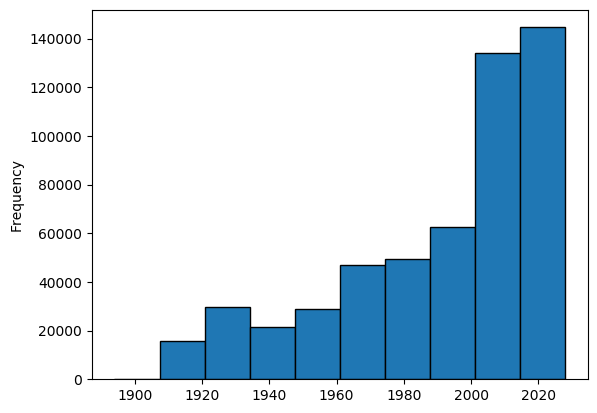

In [11]:
%matplotlib inline
title_basics_processed['startYear'].plot(kind='hist', edgecolor='black')

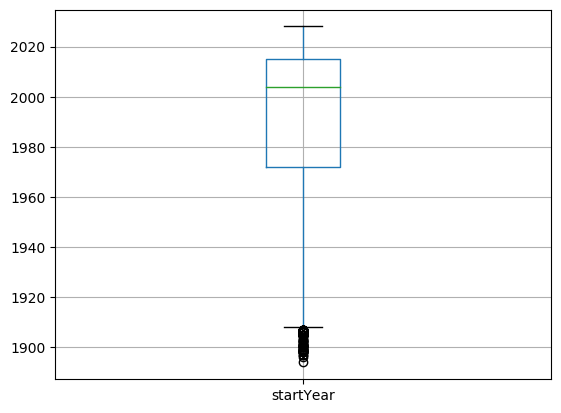

In [12]:
%matplotlib inline
# Some more detail , lets do a box plot to find the percentile distribution 
# and quartile ranges to figure out the distribution
title_basics_processed.boxplot(column='startYear', return_type='axes');

In [13]:
#clean up start year values
print(title_basics_processed['startYear'].quantile(0.10))
print(title_basics_processed['startYear'].quantile(0.90))
print(title_basics_processed['startYear'].skew())

1938.0
2020.0
-0.995550735279642


In [14]:
import numpy as np
# A strategy for imputation
title_basics_processed["startYear"] = np.where(title_basics_processed["startYear"] <1938.0, 1938.0,title_basics_processed['startYear'])
title_basics_processed["startYear"] = np.where(title_basics_processed["startYear"] >2020.0, 2020.0,title_basics_processed['startYear'])
print(title_basics_processed['startYear'].skew())

-0.7954828274994374


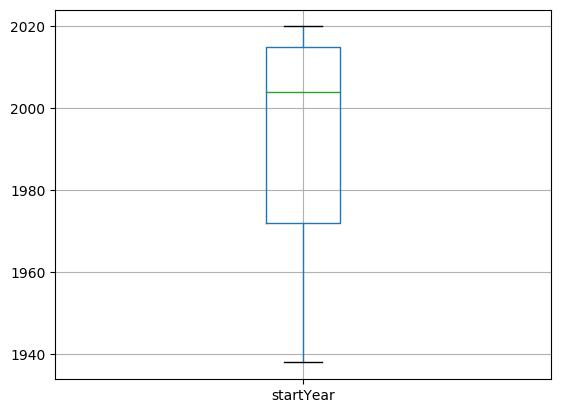

In [15]:
%matplotlib inline
#the distribution of data now looks better
title_basics_processed.boxplot(column='startYear', return_type='axes');

In [16]:
#Convert year to float
title_basics_processed.startYear = title_basics_processed.startYear.apply(int)
title_basics_processed.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,1938,45,Romance
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1938,100,"Documentary,News,Sport"
498,tt0000502,Bohemios,Bohemios,1938,100,\N
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1938,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,1938,90,Drama


In [17]:
title_basics_processed['runtimeMinutes'] = pd.to_numeric(title_basics_processed['runtimeMinutes'],errors='coerce')
title_basics_processed.dropna()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,1938,45.0,Romance
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1938,100.0,"Documentary,News,Sport"
498,tt0000502,Bohemios,Bohemios,1938,100.0,\N
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1938,70.0,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,1938,90.0,Drama
...,...,...,...,...,...,...
9469796,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
9469837,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.0,Documentary
9469864,tt9916680,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,2007,100.0,Documentary
9469887,tt9916730,6 Gunn,6 Gunn,2017,116.0,\N


In [18]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533548 entries, 8 to 9469897
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          533548 non-null  object 
 1   primaryTitle    533548 non-null  object 
 2   originalTitle   533548 non-null  object 
 3   startYear       533548 non-null  int64  
 4   runtimeMinutes  384589 non-null  float64
 5   genres          533548 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 28.5+ MB


In [19]:
title_basics_processed = title_basics_processed.dropna()
title_basics_processed.runtimeMinutes = title_basics_processed.runtimeMinutes.apply(int)
print(title_basics_processed.head())

        tconst                   primaryTitle                  originalTitle  \
8    tt0000009                     Miss Jerry                     Miss Jerry   
144  tt0000147  The Corbett-Fitzsimmons Fight  The Corbett-Fitzsimmons Fight   
498  tt0000502                       Bohemios                       Bohemios   
570  tt0000574    The Story of the Kelly Gang    The Story of the Kelly Gang   
587  tt0000591               The Prodigal Son              L'enfant prodigue   

     startYear  runtimeMinutes                      genres  
8         1938              45                     Romance  
144       1938             100      Documentary,News,Sport  
498       1938             100                          \N  
570       1938              70  Action,Adventure,Biography  
587       1938              90                       Drama  


In [20]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384589 entries, 8 to 9469897
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          384589 non-null  object
 1   primaryTitle    384589 non-null  object
 2   originalTitle   384589 non-null  object
 3   startYear       384589 non-null  int64 
 4   runtimeMinutes  384589 non-null  int64 
 5   genres          384589 non-null  object
dtypes: int64(2), object(4)
memory usage: 20.5+ MB


In [21]:
title_basics_processed = title_basics_processed[title_basics_processed.runtimeMinutes != '\\N']
title_basics_processed.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,1938,45,Romance
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1938,100,"Documentary,News,Sport"
498,tt0000502,Bohemios,Bohemios,1938,100,\N
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1938,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,1938,90,Drama


In [22]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384589 entries, 8 to 9469897
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          384589 non-null  object
 1   primaryTitle    384589 non-null  object
 2   originalTitle   384589 non-null  object
 3   startYear       384589 non-null  int64 
 4   runtimeMinutes  384589 non-null  int64 
 5   genres          384589 non-null  object
dtypes: int64(2), object(4)
memory usage: 20.5+ MB


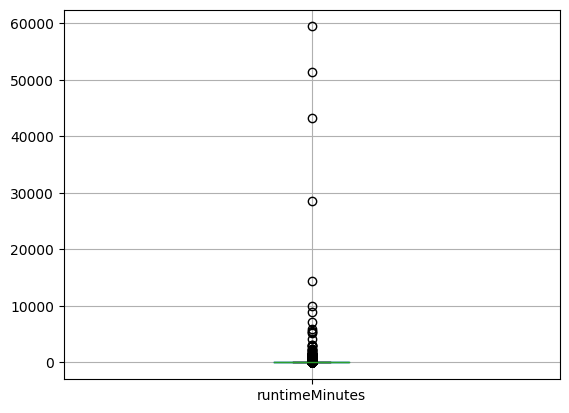

In [23]:
%matplotlib inline
# title_basics_processed.info()
title_basics_processed.boxplot(column='runtimeMinutes', return_type='axes');

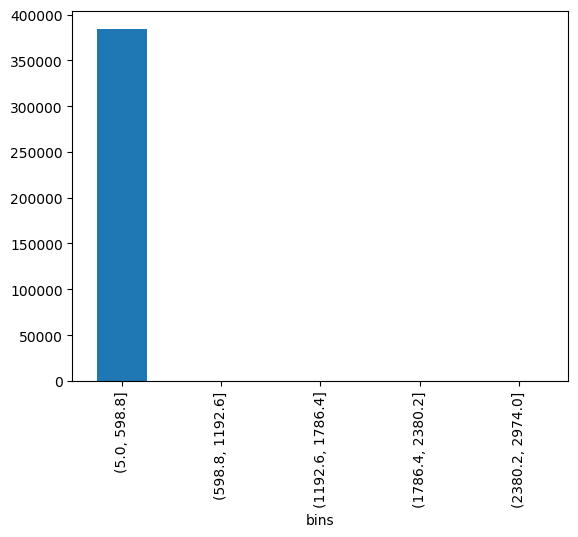

In [24]:
import matplotlib.pyplot as plt

# create a sample dataframe
title_basics_processed_visual = title_basics_processed

# create an array of bin edges
bin_edges = np.linspace(5, 2974, num=6)

# create bins and assign to a new column
title_basics_processed_visual['bins'] = pd.cut(title_basics_processed_visual['runtimeMinutes'], bin_edges)

# use groupby and plot
title_basics_processed_visual.groupby('bins').size().plot(kind='bar')
plt.show()


In [25]:
#So it seems like most of the runtimeMinutes is within 600 mins
#so lets get the unecessarey values out of the data set
title_basics_processed = title_basics_processed[title_basics_processed.runtimeMinutes <= 600]
#remove movies with duration more than 10 hours
max_elements = title_basics_processed.max()
print(max_elements)
title_basics_processed.nunique(axis=0)
title_basics_processed.head()

tconst                                                    tt9916754
primaryTitle      Šentilj-Spielfeld - Border Crossing That Once Was
originalTitle                             è solo questione di tempo
startYear                                                      2020
runtimeMinutes                                                  600
genres                                                           \N
bins                                                (598.8, 1192.6]
dtype: object


,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,bins
8,tt0000009,Miss Jerry,Miss Jerry,1938,45,Romance,"(5.0, 598.8]"
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1938,100,"Documentary,News,Sport","(5.0, 598.8]"
498,tt0000502,Bohemios,Bohemios,1938,100,\N,"(5.0, 598.8]"
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1938,70,"Action,Adventure,Biography","(5.0, 598.8]"
587,tt0000591,The Prodigal Son,L'enfant prodigue,1938,90,Drama,"(5.0, 598.8]"


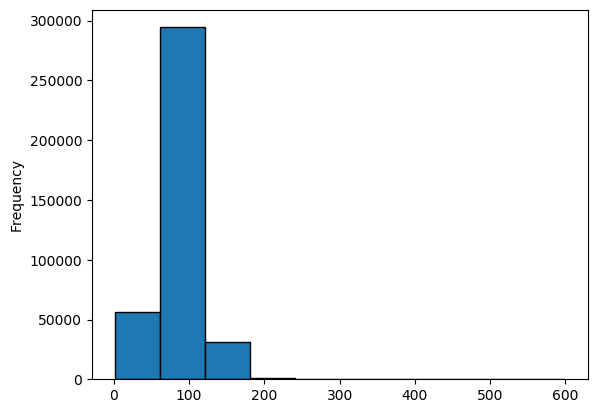

In [26]:
%matplotlib inline

title_basics_processed['runtimeMinutes'].plot(kind='hist', edgecolor='black')

In [27]:
### transform genre CSV type feature to one-hot-encoding like columns for ML usage

title_basics_processed = title_basics_processed[title_basics_processed.genres != '\\N']

genre_split = list(title_basics_processed.genres)
genre_split = ','.join(genre_split)
genre_split = genre_split.split(',')
genre_split = list(set(genre_split))
for k in genre_split:
    title_basics_processed[k] = 0
    
for k in title_basics_processed.index:
    x = title_basics_processed['genres'][k].split(',')
    for j in x:
        title_basics_processed[j][k] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [28]:
title_basics_processed.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,bins,Biography,History,Adult,...,Reality-TV,Animation,Musical,Fantasy,Game-Show,Crime,Mystery,Family,Sci-Fi,Music
8,tt0000009,Miss Jerry,Miss Jerry,1938,45,Romance,"(5.0, 598.8]",0,0,0,...,0,0,0,0,0,0,0,0,0,0
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1938,100,"Documentary,News,Sport","(5.0, 598.8]",0,0,0,...,0,0,0,0,0,0,0,0,0,0
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1938,70,"Action,Adventure,Biography","(5.0, 598.8]",1,0,0,...,0,0,0,0,0,0,0,0,0,0
587,tt0000591,The Prodigal Son,L'enfant prodigue,1938,90,Drama,"(5.0, 598.8]",0,0,0,...,0,0,0,0,0,0,0,0,0,0
672,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1938,120,"Adventure,Fantasy","(5.0, 598.8]",0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [29]:
title_basics_processed = title_basics_processed.drop(columns = ["bins","genres"] )
title_basics_processed.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Biography,History,Adult,Comedy,Action,...,Reality-TV,Animation,Musical,Fantasy,Game-Show,Crime,Mystery,Family,Sci-Fi,Music
8,tt0000009,Miss Jerry,Miss Jerry,1938,45,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1938,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1938,70,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
587,tt0000591,The Prodigal Son,L'enfant prodigue,1938,90,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
672,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1938,120,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [30]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360762 entries, 8 to 9469897
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          360762 non-null  object
 1   primaryTitle    360762 non-null  object
 2   originalTitle   360762 non-null  object
 3   startYear       360762 non-null  int64 
 4   runtimeMinutes  360762 non-null  int64 
 5   Biography       360762 non-null  int64 
 6   History         360762 non-null  int64 
 7   Adult           360762 non-null  int64 
 8   Comedy          360762 non-null  int64 
 9   Action          360762 non-null  int64 
 10  Documentary     360762 non-null  int64 
 11  War             360762 non-null  int64 
 12  Adventure       360762 non-null  int64 
 13  Thriller        360762 non-null  int64 
 14  Western         360762 non-null  int64 
 15  Sport           360762 non-null  int64 
 16  Talk-Show       360762 non-null  int64 
 17  Drama           360762 non-n

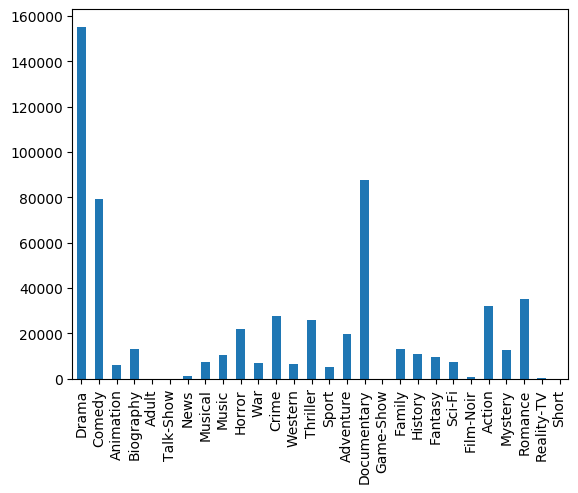

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt


title_basics_processed[['Drama','Comedy','Animation','Biography',
                        'Adult','Talk-Show','News','Musical','Music',
                       'Horror','War','Crime','Western','Thriller','Sport',
                        'Adventure','Documentary','Game-Show','Family','History',
                       'Fantasy','Sci-Fi','Film-Noir','Action','Mystery','Romance','Reality-TV','Short']].sum().plot.bar()

plt.show()

In [32]:
title_basics_processed = title_basics_processed.sort_index()
title_basics_processed

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Biography,History,Adult,Comedy,Action,...,Reality-TV,Animation,Musical,Fantasy,Game-Show,Crime,Mystery,Family,Sci-Fi,Music
8,tt0000009,Miss Jerry,Miss Jerry,1938,45,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1938,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1938,70,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
587,tt0000591,The Prodigal Son,L'enfant prodigue,1938,90,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
672,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1938,120,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9469712,tt9916362,Coven,Akelarre,2020,92,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9469796,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9469837,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9469864,tt9916680,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,2007,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
title_basics_processed = title_basics_processed.drop(columns= ['Short','Reality-TV'])
title_basics_processed = title_basics_processed.drop(columns= ['Game-Show','Talk-Show','Adult'])
# title_basics_processed = title_basics_processed.drop(columns= ['index']) #no puprpose of this index , but in my case I didnt have this column, in case its there uncomment and run this
title_basics_processed.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Biography,History,Comedy,Action,Documentary,...,Film-Noir,Horror,Animation,Musical,Fantasy,Crime,Mystery,Family,Sci-Fi,Music
8,tt0000009,Miss Jerry,Miss Jerry,1938,45,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1938,100,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1938,70,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
587,tt0000591,The Prodigal Son,L'enfant prodigue,1938,90,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
672,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1938,120,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [34]:
title_basics_processed = title_basics_processed.dropna()
title_basics_processed.nunique(axis=0)
title_basics_processed.shape

(360762, 28)

In [35]:
# We will see how to merge the attributes of the 2 data sets to have a holistic data 
# set that we will be using going forward
# this data set has ratings and votes
title_ratings ='csv_files/title.ratings.tsv'
obj = s3.get_object(Bucket = bucket_name,Key = title_ratings)
df_title_ratings = pd.read_table(obj['Body'])
df_title_ratings.dropna()
df_title_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1930
1,tt0000002,5.8,261
2,tt0000003,6.5,1745
3,tt0000004,5.6,176
4,tt0000005,6.2,2560


In [36]:
final = pd.merge(left=title_basics_processed, right=df_title_ratings, on='tconst')
final.shape

(246914, 30)

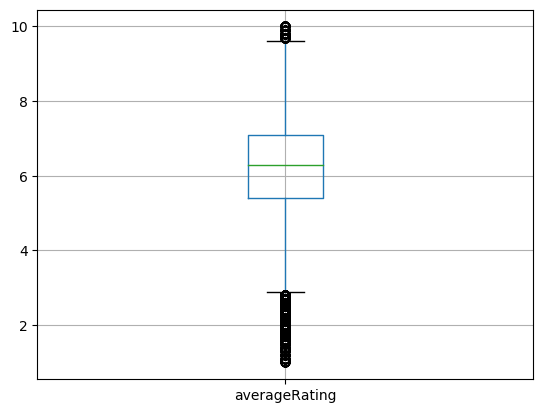

In [37]:
%matplotlib inline
final.boxplot(column='averageRating', return_type='axes');

In [38]:
final.describe()

,startYear,runtimeMinutes,Biography,History,Comedy,Action,Documentary,War,Adventure,Thriller,...,Animation,Musical,Fantasy,Crime,Mystery,Family,Sci-Fi,Music,averageRating,numVotes
count,246914.000000,246914.000000,246914.000000,246914.000000,246914.000000,246914.000000,246914.000000,246914.000000,246914.000000,246914.000000,...,246914.000000,246914.000000,246914.000000,246914.000000,246914.000000,246914.000000,246914.000000,246914.000000,246914.000000,2.469140e+05
mean,1994.895684,94.090477,0.034133,0.030278,0.261626,0.106361,0.162081,0.022891,0.066926,0.088816,...,0.018541,0.022988,0.031582,0.093450,0.041472,0.041087,0.025470,0.028990,6.183915,4.101846e+03
std,24.842108,24.504975,0.181572,0.171351,0.439521,0.308300,0.368526,0.149555,0.249895,0.284479,...,0.134897,0.149865,0.174884,0.291062,0.199379,0.198492,0.157549,0.167778,1.333490,3.721378e+04
min,1938.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000e+00
25%,1978.000000,81.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.400000,2.300000e+01
50%,2005.000000,91.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.300000,8.100000e+01
75%,2015.000000,103.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.100000,4.060000e+02
max,2020.000000,580.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,2.673885e+06


In [39]:
# Makes sense to trim down numvotes >=5 ?
final = final[final.averageRating >= 5]
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205199 entries, 0 to 246913
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          205199 non-null  object 
 1   primaryTitle    205199 non-null  object 
 2   originalTitle   205199 non-null  object 
 3   startYear       205199 non-null  int64  
 4   runtimeMinutes  205199 non-null  int64  
 5   Biography       205199 non-null  int64  
 6   History         205199 non-null  int64  
 7   Comedy          205199 non-null  int64  
 8   Action          205199 non-null  int64  
 9   Documentary     205199 non-null  int64  
 10  War             205199 non-null  int64  
 11  Adventure       205199 non-null  int64  
 12  Thriller        205199 non-null  int64  
 13  Western         205199 non-null  int64  
 14  Sport           205199 non-null  int64  
 15  Drama           205199 non-null  int64  
 16  Romance         205199 non-null  int64  
 17  News      

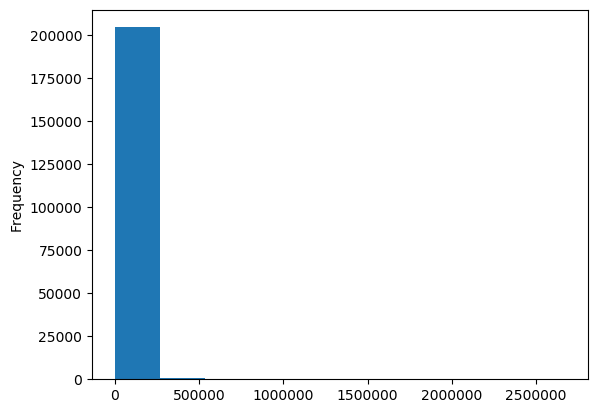

In [40]:
%matplotlib inline
final['numVotes'].plot(kind='hist')

In [41]:

final.dropna()
min_value = final['numVotes'].min()
max_value = final['numVotes'].max()
print(min_value)
print(max_value)

# print(final.info) #205199 rows

5
2673885


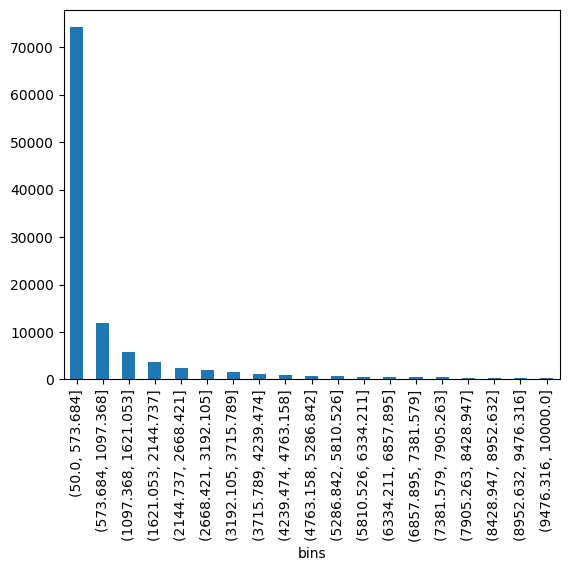

In [42]:
import matplotlib.pyplot as plt

# create a sample dataframe
final_visual = final

# create an array of bin edges
# 2673885,297102,33015,3672
bin_edges = np.linspace(50, 10000, num=20)

# create bins and assign to a new column
final_visual['bins'] = pd.cut(final_visual['numVotes'], bin_edges)

# use groupby and plot
final_visual.groupby('bins').size().plot(kind='bar')
plt.show()

In [43]:
final = final[(final.numVotes >= 50) ]
final = final[(final.numVotes <= 10000) ]
final.dropna()
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109586 entries, 0 to 246912
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   tconst          109586 non-null  object  
 1   primaryTitle    109586 non-null  object  
 2   originalTitle   109586 non-null  object  
 3   startYear       109586 non-null  int64   
 4   runtimeMinutes  109586 non-null  int64   
 5   Biography       109586 non-null  int64   
 6   History         109586 non-null  int64   
 7   Comedy          109586 non-null  int64   
 8   Action          109586 non-null  int64   
 9   Documentary     109586 non-null  int64   
 10  War             109586 non-null  int64   
 11  Adventure       109586 non-null  int64   
 12  Thriller        109586 non-null  int64   
 13  Western         109586 non-null  int64   
 14  Sport           109586 non-null  int64   
 15  Drama           109586 non-null  int64   
 16  Romance         109586 non-null  int64

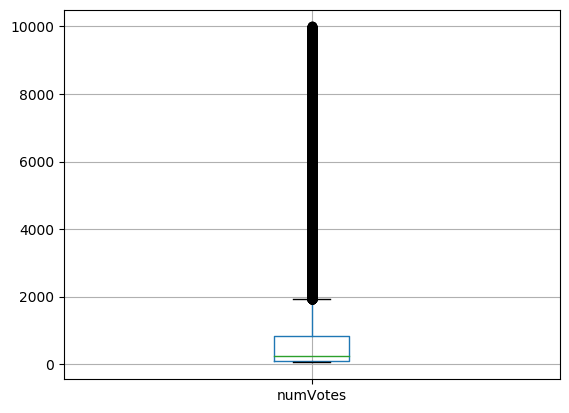

In [44]:
%matplotlib inline

final.boxplot(column='numVotes', return_type='axes');

In [45]:
final = final[(final.numVotes >= 50) ]
final = final[(final.numVotes <= 2000) ]
final.dropna()
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95489 entries, 0 to 246911
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tconst          95489 non-null  object  
 1   primaryTitle    95489 non-null  object  
 2   originalTitle   95489 non-null  object  
 3   startYear       95489 non-null  int64   
 4   runtimeMinutes  95489 non-null  int64   
 5   Biography       95489 non-null  int64   
 6   History         95489 non-null  int64   
 7   Comedy          95489 non-null  int64   
 8   Action          95489 non-null  int64   
 9   Documentary     95489 non-null  int64   
 10  War             95489 non-null  int64   
 11  Adventure       95489 non-null  int64   
 12  Thriller        95489 non-null  int64   
 13  Western         95489 non-null  int64   
 14  Sport           95489 non-null  int64   
 15  Drama           95489 non-null  int64   
 16  Romance         95489 non-null  int64   
 17  News       

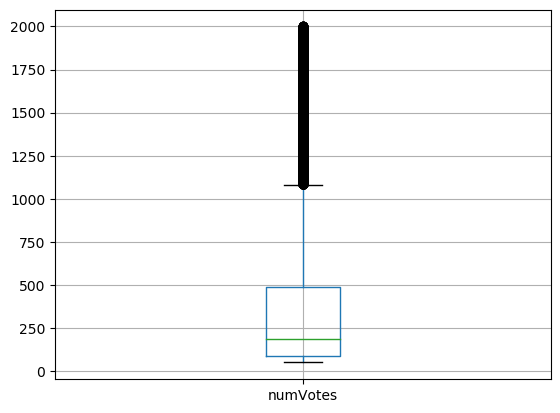

In [46]:
%matplotlib inline

final.boxplot(column='numVotes', return_type='axes');

In [47]:
final = final[(final.numVotes >= 50) ]
final = final[(final.numVotes <= 400) ]
final.dropna()
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67219 entries, 0 to 246908
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tconst          67219 non-null  object  
 1   primaryTitle    67219 non-null  object  
 2   originalTitle   67219 non-null  object  
 3   startYear       67219 non-null  int64   
 4   runtimeMinutes  67219 non-null  int64   
 5   Biography       67219 non-null  int64   
 6   History         67219 non-null  int64   
 7   Comedy          67219 non-null  int64   
 8   Action          67219 non-null  int64   
 9   Documentary     67219 non-null  int64   
 10  War             67219 non-null  int64   
 11  Adventure       67219 non-null  int64   
 12  Thriller        67219 non-null  int64   
 13  Western         67219 non-null  int64   
 14  Sport           67219 non-null  int64   
 15  Drama           67219 non-null  int64   
 16  Romance         67219 non-null  int64   
 17  News       

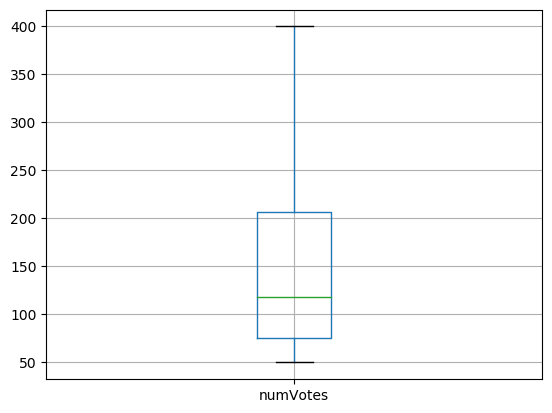

In [48]:
%matplotlib inline
final.boxplot(column='numVotes', return_type='axes');

In [49]:
#shuffle 
final = final.sample(frac=1, random_state=42)

In [50]:
final.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Biography,History,Comedy,Action,Documentary,...,Musical,Fantasy,Crime,Mystery,Family,Sci-Fi,Music,averageRating,numVotes,bins
107957,tt0398212,After the Day Before,Másnap,2004,120,0,0,0,0,0,...,0,0,1,0,0,0,0,6.9,333,"(50.0, 573.684]"
58927,tt0114574,The Suburbanators,The Suburbanators,1995,87,0,0,1,0,0,...,0,0,0,0,0,0,0,7.0,69,"(50.0, 573.684]"
77263,tt0193706,Afraid of Everything,Afraid of Everything,1999,80,0,0,0,0,0,...,0,0,0,0,0,0,0,7.0,77,"(50.0, 573.684]"
200045,tt3645074,The Gold Bug,El escarabajo de oro,2014,100,0,1,0,0,0,...,0,0,0,0,0,0,0,6.4,175,"(50.0, 573.684]"
24949,tt0054271,Holiday in Spain,Scent of Mystery,1960,125,0,0,0,0,0,...,0,0,1,1,0,0,0,5.5,378,"(50.0, 573.684]"


In [51]:
final = final.sort_index()
final = final.reset_index()

In [52]:
final=final.drop(['index'], axis = 1)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67219 entries, 0 to 67218
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tconst          67219 non-null  object  
 1   primaryTitle    67219 non-null  object  
 2   originalTitle   67219 non-null  object  
 3   startYear       67219 non-null  int64   
 4   runtimeMinutes  67219 non-null  int64   
 5   Biography       67219 non-null  int64   
 6   History         67219 non-null  int64   
 7   Comedy          67219 non-null  int64   
 8   Action          67219 non-null  int64   
 9   Documentary     67219 non-null  int64   
 10  War             67219 non-null  int64   
 11  Adventure       67219 non-null  int64   
 12  Thriller        67219 non-null  int64   
 13  Western         67219 non-null  int64   
 14  Sport           67219 non-null  int64   
 15  Drama           67219 non-null  int64   
 16  Romance         67219 non-null  int64   
 17  News        

In [53]:
#Columns to be saved for later use , since some columns are not needed for tarining the recommendation algorithm
movie_data = final[['tconst','primaryTitle','originalTitle']].copy()
final=final.drop(['tconst','primaryTitle','originalTitle'], axis = 1)

In [54]:
final = final.drop(['bins'],axis = 1)
change_column = ['startYear','runtimeMinutes','Thriller','Music','Documentary','Film-Noir','War','History','Animation','Biography','Horror','Adventure',
                 'Sport','News','Musical','Mystery','Action','Comedy','Sci-Fi','Crime','Romance','Fantasy','Western','Drama','Family','averageRating','numVotes']
final = final.reindex(columns=change_column)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67219 entries, 0 to 67218
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startYear       67219 non-null  int64  
 1   runtimeMinutes  67219 non-null  int64  
 2   Thriller        67219 non-null  int64  
 3   Music           67219 non-null  int64  
 4   Documentary     67219 non-null  int64  
 5   Film-Noir       67219 non-null  int64  
 6   War             67219 non-null  int64  
 7   History         67219 non-null  int64  
 8   Animation       67219 non-null  int64  
 9   Biography       67219 non-null  int64  
 10  Horror          67219 non-null  int64  
 11  Adventure       67219 non-null  int64  
 12  Sport           67219 non-null  int64  
 13  News            67219 non-null  int64  
 14  Musical         67219 non-null  int64  
 15  Mystery         67219 non-null  int64  
 16  Action          67219 non-null  int64  
 17  Comedy          67219 non-null 

In [55]:
pip show joblib

Name: joblib
Version: 1.2.0
Summary: Lightweight pipelining with Python functions
Home-page: https://joblib.readthedocs.io
Author: Gael Varoquaux
Author-email: gael.varoquaux@normalesup.org
License: BSD
Location: /opt/conda/lib/python3.7/site-packages
Requires: 
Required-by: nltk, scikit-learn
Note: you may need to restart the kernel to use updated packages.


In [56]:
# Scaling of the final dataset
# We will be saving this model for use later on in real time predictions

from sklearn.preprocessing import StandardScaler
import joblib as joblib

# create a scaler object
column_list = list(final.columns)
print(column_list)

scaler = StandardScaler()
scaler.fit(final)
joblib.dump(scaler, 'model.joblib')


df_final_standardized = scaler.transform(final).astype(np.float32) 
#When we create the sagemaker pipeline , this should be automatically handled for us

['startYear', 'runtimeMinutes', 'Thriller', 'Music', 'Documentary', 'Film-Noir', 'War', 'History', 'Animation', 'Biography', 'Horror', 'Adventure', 'Sport', 'News', 'Musical', 'Mystery', 'Action', 'Comedy', 'Sci-Fi', 'Crime', 'Romance', 'Fantasy', 'Western', 'Drama', 'Family', 'averageRating', 'numVotes']


In [57]:
# This is where we will everything
bucket_name='awesome2023-545313841491'

In [58]:
#upload the standard scalar model to the s3 bucket
session = boto3.Session()
s3 = session.client('s3')
role = get_execution_role()
scaler_key = 'model.joblib'
s3.upload_file('model.joblib', bucket_name, scaler_key)

In [61]:
#just testing purpose
from pandas.io.json import json_normalize
import json
import joblib
model_trial = joblib.load("model.joblib")

print(column_list)
# JSON key/value features
# json_string = '{"startYear":[2010], "runtimeMinutes":[150], "Documentary":[0], "News":[0],"Action":[0],"Musical":[0],"Adventure":[0], "Sci-Fi":[1],"History":[0],"Mystery":[0],"Horror":[1], "Fantasy":[0],"War":[0], "Romance":[0], "Music":[0], "Biography":[0], "Sport":[0],"Drama":[1],"Western":[0], "Film-Noir": [0],"Comedy":[0], "Family":[1],"Crime":[1],"Animation":[0],"Thriller":[0],"averageRating":[5.3],"numVotes": [8000]}'


json_string = '{"startYear":[2015],"runtimeMinutes":[150],"Thriller":[1],"Music":[0],"Documentary":[0],"Film-Noir":[0],"War":[0],"History":[0],"Animation":[0],"Biography":[0],"Horror":[0],"Adventure":[1],"Sport":[0],"News":[0],"Musical":[0],"Mystery":[0],"Action":[1],"Comedy":[0],"Sci-Fi":[1],"Crime":[1],"Romance":[0],"Fantasy":[0],"Western":[0],"Drama":[0],"Family":[0],"averageRating":[7],"numVotes":[50]}'

# Convert the json string to a python dictionary
json_dict = json.loads(json_string)

# Normalize the json_dict to create a dataframe
json_dict_df = pd.DataFrame(json_dict)

# json_dict_df_from_model = scaler.transform(json_dict_df).astype('float32')
json_dict_df_from_model = model_trial.transform(json_dict_df).astype('float32')
json_dict_df_from_model #this is numpy array

# convert numpy array to list
json_dict_df_from_model = json_dict_df_from_model.tolist()

# convert list to json
json_response = json.dumps(json_dict_df_from_model)
respJSON = {'Output': json_response}
respJSON

['startYear', 'runtimeMinutes', 'Thriller', 'Music', 'Documentary', 'Film-Noir', 'War', 'History', 'Animation', 'Biography', 'Horror', 'Adventure', 'Sport', 'News', 'Musical', 'Mystery', 'Action', 'Comedy', 'Sci-Fi', 'Crime', 'Romance', 'Fantasy', 'Western', 'Drama', 'Family', 'averageRating', 'numVotes']


{'Output': '[[0.8855440616607666, 2.2639517784118652, 3.7217934131622314, -0.18072344362735748, -0.4244655668735504, -0.06362324953079224, -0.16373340785503387, -0.1832536906003952, -0.1356191188097, -0.18308018147945404, -0.19453215599060059, 4.018420696258545, -0.11792843043804169, -0.049755942076444626, -0.1617104709148407, -0.19275420904159546, 3.2786459922790527, -0.5977928638458252, 8.208622932434082, 3.153435468673706, -0.38422682881355286, -0.16999703645706177, -0.16696204245090485, -1.037368893623352, -0.21805289387702942, 0.6696339249610901, -1.0824720859527588]]'}

In [62]:
df_final_standardized = pd.DataFrame(df_final_standardized)
df_final_standardized.columns = column_list
df_final_standardized.head()

,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,War,History,Animation,Biography,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
0,-2.051811,-2.038425,-0.268688,-0.180723,-0.424466,-0.063623,-0.163733,-0.183254,-0.135619,-0.183080,...,-0.597793,-0.121823,-0.317114,2.602629,-0.169997,-0.166962,-1.037369,-0.218053,-1.306433,0.544271
1,-2.051811,1.034701,-0.268688,-0.180723,-0.424466,-0.063623,-0.163733,-0.183254,-0.135619,-0.183080,...,-0.597793,-0.121823,-0.317114,-0.384227,5.882456,-0.166962,-1.037369,-0.218053,-1.422672,-0.910102
2,-2.051811,-1.833550,-0.268688,-0.180723,-0.424466,-0.063623,-0.163733,-0.183254,-0.135619,5.462088,...,-0.597793,-0.121823,-0.317114,-0.384227,-0.169997,-0.166962,0.963977,4.586043,-1.073954,-0.996287
3,-2.051811,-1.710625,-0.268688,-0.180723,-0.424466,-0.063623,-0.163733,-0.183254,-0.135619,-0.183080,...,-0.597793,-0.121823,-0.317114,-0.384227,-0.169997,-0.166962,0.963977,-0.218053,-0.608997,0.985970
4,-2.051811,-1.915501,-0.268688,-0.180723,-0.424466,-0.063623,-0.163733,-0.183254,-0.135619,-0.183080,...,-0.597793,-0.121823,-0.317114,-0.384227,-0.169997,-0.166962,0.963977,-0.218053,-0.492758,-0.694639


In [63]:
# this will train on the data set that we have , to find clusters
# this will take time , so for the workshop we will need to distribute it via s3 bucket and a presigned url ?
# from time import gmtime, strftime
# from sagemaker import KMeans
# output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
# output_folder = 'KMeans-results-v2-' + output_time
# K = range(2, 51) # change the range to be used for k
# job_names = []

# # launching jobs for all k
# for k in K:
#     print('starting train job for cluster with k:' + str(k))
#     output_location = 's3://{}/kmeans_movieoutput/'.format(bucket_name) + output_folder
#     print('training artifacts will be uploaded to: {}'.format(output_location))
#     job_name = 'movierecommender-AWEsome-' + str(k)
    
#     kmeans = KMeans(role=role, instance_count=1, instance_type='ml.c4.xlarge', init_method='kmeans++', 
#                 output_path=output_location, k=k, epochs=5) 
#     kmeans.fit(kmeans.record_set(df_final_standardized.values), job_name=job_name)
    
#     job_names.append(job_name)
#     print('end of train job for cluster: ' + str(k))

In [64]:
!pip install mxnet
print(bucket_name)

awesome2023-545313841491


kmeans_movieoutput/KMeans-results-v2-2023-03-19-04-25-50/movierecommender-AWEsome-2/output/model.tar.gz
Model for k=2 (kmeans_movieoutput/KMeans-results-v2-2023-03-19-04-25-50/movierecommender-AWEsome-2/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-03-19-04-25-50/movierecommender-AWEsome-3/output/model.tar.gz
Model for k=3 (kmeans_movieoutput/KMeans-results-v2-2023-03-19-04-25-50/movierecommender-AWEsome-3/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-03-19-04-25-50/movierecommender-AWEsome-4/output/model.tar.gz
Model for k=4 (kmeans_movieoutput/KMeans-results-v2-2023-03-19-04-25-50/movierecommender-AWEsome-4/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-03-19-04-25-50/movierecommender-AWEsome-5/output/model.tar.gz
Model for k=5 (kmeans_movieoutput/KMeans-results-v2-2023-03-19-04-25-50/movierecommender-AWEsome-5/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-03-19-04-2

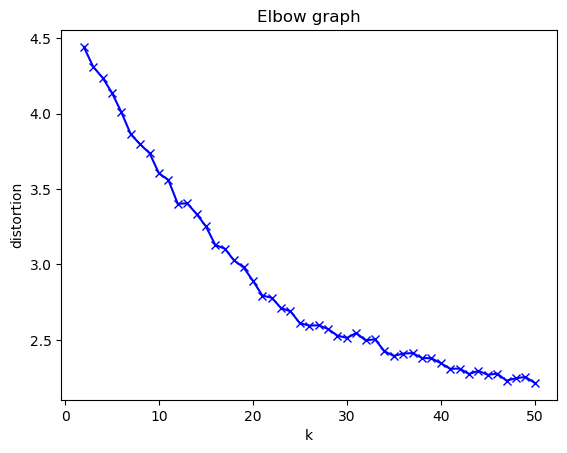

In [65]:
#use already trained models in s3 to find what is the appropriate number of clusters
#need to use a different way to find the elbow graph of a sagemaker trained kmeans model as opposed to
#sklearn k means
import mxnet as mx
from scipy.spatial.distance import cdist
markers = ['o', 'v', 's']
models = {}
distortions = []
output_folder = 'kmeans_movieoutput/';
result_folder = 'KMeans-results-v2-2023-03-19-04-25-50/'
final_folder ='movierecommender-AWEsome-'
K = range(2, 51) # change the range to be used for k
for k in K:
    s3_client = boto3.client('s3')
    key = output_folder + result_folder + final_folder+str(k) +  '/output/model.tar.gz'
    print(key)
    s3_client.download_file(bucket_name, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar --no-same-owner -xvf model.tar.gz                       
    kmeans_model=mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()
    distortions.append(sum(np.min(cdist(df_final_standardized.values, kmeans_numpy, 'euclidean'), axis=1)) / df_final_standardized.values.shape[0])
    models[k] = kmeans_numpy
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow graph')
plt.show()

In [67]:
#above steps were done to find the optimal number of clusters.
#once that is known , I train the model for k=25 and then deploy the model

from sagemaker import KMeans
kmeans = KMeans(role=role,
                instance_count=1,
                instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name + '/',
                init_method='kmeans++',
                k=25, 
                epochs=5)
kmeans.fit(kmeans.record_set(df_final_standardized.values))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2023-03-23-23-54-23-636


2023-03-23 23:54:26 Starting - Starting the training job...
2023-03-23 23:54:50 Starting - Preparing the instances for training......
2023-03-23 23:55:46 Downloading - Downloading input data...
2023-03-23 23:56:11 Training - Downloading the training image......
2023-03-23 23:57:26 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/23/2023 23:57:35 INFO 140343466878784] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '

In [68]:
#deploy a trained model
#After executing this cell the Kmeans model will be deployed

kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2023-03-23-23-58-16-439
INFO:sagemaker:Creating endpoint-config with name kmeans-2023-03-23-23-58-16-439
INFO:sagemaker:Creating endpoint with name kmeans-2023-03-23-23-58-16-439


------!

In [73]:
df_final_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67219 entries, 0 to 67218
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startYear       67219 non-null  float32
 1   runtimeMinutes  67219 non-null  float32
 2   Thriller        67219 non-null  float32
 3   Music           67219 non-null  float32
 4   Documentary     67219 non-null  float32
 5   Film-Noir       67219 non-null  float32
 6   War             67219 non-null  float32
 7   History         67219 non-null  float32
 8   Animation       67219 non-null  float32
 9   Biography       67219 non-null  float32
 10  Horror          67219 non-null  float32
 11  Adventure       67219 non-null  float32
 12  Sport           67219 non-null  float32
 13  News            67219 non-null  float32
 14  Musical         67219 non-null  float32
 15  Mystery         67219 non-null  float32
 16  Action          67219 non-null  float32
 17  Comedy          67219 non-null 

In [74]:
train_data1 = df_final_standardized[0:40000]
train_data2 = df_final_standardized[40000:67219]
# train_data3 = df_final_standardized[80000:91815]


result1=kmeans_predictor.predict(train_data1.values)
result2=kmeans_predictor.predict(train_data2.values)
# result3=kmeans_predictor.predict(train_data3.values)

result = result1 + result2 

In [75]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
predictions = pd.DataFrame(data=cluster_labels)

In [76]:
predictions.info

<bound method DataFrame.info of           0
0      23.0
1      21.0
2       9.0
3       2.0
4       2.0
...     ...
67214  19.0
67215   4.0
67216   1.0
67217   4.0
67218   4.0

[67219 rows x 1 columns]>

In [77]:
column_list

['startYear',
 'runtimeMinutes',
 'Thriller',
 'Music',
 'Documentary',
 'Film-Noir',
 'War',
 'History',
 'Animation',
 'Biography',
 'Horror',
 'Adventure',
 'Sport',
 'News',
 'Musical',
 'Mystery',
 'Action',
 'Comedy',
 'Sci-Fi',
 'Crime',
 'Romance',
 'Fantasy',
 'Western',
 'Drama',
 'Family',
 'averageRating',
 'numVotes']

In [78]:
#this pred_final data needs to be saved so that it can be used for lookup during real time predictions
pred_info = pd.concat([predictions, final], axis=1)
pred_info = pred_info.rename(columns={0: 'cluster'})
pred_final = pd.concat([movie_data, pred_info], axis=1)
pred_final

,tconst,primaryTitle,originalTitle,cluster,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
0,tt0000009,Miss Jerry,Miss Jerry,23.0,1938,45,0,0,0,0,...,0,0,0,1,0,0,0,0,5.3,201
1,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,21.0,1938,120,0,0,0,0,...,0,0,0,0,1,0,0,0,5.2,66
2,tt0001285,The Life of Moses,The Life of Moses,9.0,1938,50,0,0,0,0,...,0,0,0,0,0,0,1,1,5.5,58
3,tt0001892,Den sorte drøm,Den sorte drøm,2.0,1938,53,0,0,0,0,...,0,0,0,0,0,0,1,0,5.9,242
4,tt0001964,The Traitress,Die Verräterin,2.0,1938,48,0,0,0,0,...,0,0,0,0,0,0,1,0,6.0,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67214,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,19.0,2019,98,0,0,0,0,...,0,0,0,0,0,0,1,1,5.1,217
67215,tt9914644,9/11: Escape from the Towers,9/11: Escape from the Towers,4.0,2018,120,0,0,1,0,...,0,0,0,0,0,0,0,0,8.3,107
67216,tt9914942,Life Without Sara Amat,La vida sense la Sara Amat,1.0,2019,74,0,0,0,0,...,0,0,0,0,0,0,1,0,6.7,164
67217,tt9914972,Blind Ambition,Blind Ambition,4.0,2020,96,0,0,1,0,...,0,0,0,0,0,0,0,0,7.2,200


In [157]:
data_to_predict1 = {"startYear":[2015], "runtimeMinutes":[150],"Thriller":[1],"Music":[0],"Documentary":[0],
                    "Film-Noir":[0],"War":[0],"History":[0],"Animation":[0],"Biography":[0],
                    "Horror":[0],"Adventure":[1],"Sport":[0],"News":[0],"Musical":[0],
                    "Mystery":[0],"Action":[1],"Comedy":[0],"Sci-Fi":[1],
                    "Crime":[1],"Romance":[0],"Fantasy":[0],"Western":[0],
                    "Drama":[0],"Family":[0],
                    "averageRating":[7],"numVotes":[50]}

in_data2 = pd.DataFrame(data_to_predict1)
input2 = scaler.transform(in_data2).astype('float32')
print(type(input2))
print(input2.ndim)
print(input2)
input2_pred = kmeans_predictor.predict(input2)
input2_cluster = [r.label['closest_cluster'].float32_tensor.values[0] for r in input2_pred]
#predicted cluster 
print(int(input2_cluster[0]))

<class 'numpy.ndarray'>
2
[[ 0.88554406  2.2639518   3.7217934  -0.18072344 -0.42446557 -0.06362325
  -0.16373341 -0.18325369 -0.13561912 -0.18308018 -0.19453216  4.0184207
  -0.11792843 -0.04975594 -0.16171047 -0.19275421  3.278646   -0.59779286
   8.208623    3.1534355  -0.38422683 -0.16999704 -0.16696204 -1.0373689
  -0.2180529   0.6696339  -1.0824721 ]]
12


In [158]:
recommendations = pred_final.loc[pred_final['cluster'] == 
            int(input2_cluster[0])].sort_values(by =['averageRating', 'numVotes'], ascending=False)[:10]
recommendations

,tconst,primaryTitle,originalTitle,cluster,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
43751,tt13751370,Stabiliti,Stabiliti,12.0,2020,116,0,0,0,0,...,0,1,1,0,0,0,0,0,9.2,80
41417,tt12055088,The Area 51 Incident,The Area 51 Incident,12.0,2020,81,0,0,0,0,...,0,1,0,0,0,0,0,0,8.8,248
30303,tt0290669,Inseguito,Inseguito,12.0,2002,97,1,0,0,0,...,0,1,0,0,0,0,0,0,8.7,74
50412,tt2101405,New Prime,New Prime,12.0,2011,60,0,0,0,0,...,1,1,0,0,0,0,0,0,8.6,287
66419,tt9167718,People in Landscape,People in Landscape,12.0,2020,105,0,0,0,0,...,0,1,0,0,0,0,1,0,8.6,174
60894,tt5812442,Neurogenesis,Neurogenesis,12.0,2017,65,0,0,0,0,...,0,1,0,0,0,0,0,0,8.6,79
56375,tt3770750,Tomorrow Ever After,Tomorrow Ever After,12.0,2016,95,0,0,0,0,...,1,1,0,0,0,0,0,0,8.5,85
59196,tt5038806,Infinitium,Infinitium,12.0,2017,112,0,0,0,0,...,0,1,0,0,0,0,0,0,8.4,254
51275,tt2210198,Railroader,Railroader,12.0,2012,58,0,0,0,0,...,0,1,0,0,0,0,1,0,8.4,70
56503,tt3816908,Inimigo Desconhecido: Enemy Unknown,Inimigo Desconhecido: Enemy Unknown,12.0,2020,95,0,0,0,0,...,0,1,0,0,0,0,0,0,8.1,245


In [160]:
#now perform the steps for using the sagemaker migration toolkit in your Cloud 9 environment to convert the sckit-sklearn model 
#for standardizing and deploy to sagemaker.
#After the sklearn custom model is deployed to sagemaker , we can come back and execute this cell to execute 
#the 2 API's one after another and see the cluster that is returned.
#Finally we will seee what movies are a part of that cluster that has been returned.

import boto3
import json
import numpy as np

# Create a SageMaker runtime client
client = boto3.client('runtime.sagemaker')

# Define the endpoint name and the json structure to pass to it
endpoint_name = 'sm-endpoint-sklearn-2023-03-23-22-58-49'
json_structure = {"startYear":[2015], "runtimeMinutes":[150],"Thriller":[1],"Music":[0],"Documentary":[0],
                    "Film-Noir":[0],"War":[0],"History":[0],"Animation":[0],"Biography":[0],
                    "Horror":[0],"Adventure":[1],"Sport":[0],"News":[0],"Musical":[0],
                    "Mystery":[0],"Action":[1],"Comedy":[0],"Sci-Fi":[1],
                    "Crime":[1],"Romance":[0],"Fantasy":[0],"Western":[0],
                    "Drama":[0],"Family":[0],
                    "averageRating":[7],"numVotes":[50]}


# Convert the json structure to a bytes object
payload = json.dumps(json_structure).encode('utf-8')

# Invoke the endpoint and get the response
response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=payload)

# Get the response body
response_body = response['Body'].read().decode('utf-8')

string_array = json.loads(response_body)["Output"]
np_array = np.fromstring(string_array.replace("[", "").replace("]", ""), sep=",")

arr_2d = np.reshape(np_array, (1, len(np_array)))

print(arr_2d.astype('float32'))
print(type(arr_2d))
print(arr_2d.ndim)

test_predictions = kmeans_predictor.predict(arr_2d.astype('float32'))
returned_cluster = [r.label['closest_cluster'].float32_tensor.values[0] for r in test_predictions]
#predicted cluster 
print(int(returned_cluster[0]))

recommendations_sagemaker_models = pred_final.loc[pred_final['cluster'] == 
            int(returned_cluster[0])].sort_values(by =['averageRating', 'numVotes'], ascending=False)[:10]
recommendations_sagemaker_models


[[ 0.88554406  2.2639518   3.7217934  -0.18072344 -0.42446557 -0.06362325
  -0.16373341 -0.18325369 -0.13561912 -0.18308018 -0.19453216  4.0184207
  -0.11792843 -0.04975594 -0.16171047 -0.19275421  3.278646   -0.59779286
   8.208623    3.1534355  -0.38422683 -0.16999704 -0.16696204 -1.0373689
  -0.2180529   0.6696339  -1.0824721 ]]
<class 'numpy.ndarray'>
2
12


,tconst,primaryTitle,originalTitle,cluster,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
43751,tt13751370,Stabiliti,Stabiliti,12.0,2020,116,0,0,0,0,...,0,1,1,0,0,0,0,0,9.2,80
41417,tt12055088,The Area 51 Incident,The Area 51 Incident,12.0,2020,81,0,0,0,0,...,0,1,0,0,0,0,0,0,8.8,248
30303,tt0290669,Inseguito,Inseguito,12.0,2002,97,1,0,0,0,...,0,1,0,0,0,0,0,0,8.7,74
50412,tt2101405,New Prime,New Prime,12.0,2011,60,0,0,0,0,...,1,1,0,0,0,0,0,0,8.6,287
66419,tt9167718,People in Landscape,People in Landscape,12.0,2020,105,0,0,0,0,...,0,1,0,0,0,0,1,0,8.6,174
60894,tt5812442,Neurogenesis,Neurogenesis,12.0,2017,65,0,0,0,0,...,0,1,0,0,0,0,0,0,8.6,79
56375,tt3770750,Tomorrow Ever After,Tomorrow Ever After,12.0,2016,95,0,0,0,0,...,1,1,0,0,0,0,0,0,8.5,85
59196,tt5038806,Infinitium,Infinitium,12.0,2017,112,0,0,0,0,...,0,1,0,0,0,0,0,0,8.4,254
51275,tt2210198,Railroader,Railroader,12.0,2012,58,0,0,0,0,...,0,1,0,0,0,0,1,0,8.4,70
56503,tt3816908,Inimigo Desconhecido: Enemy Unknown,Inimigo Desconhecido: Enemy Unknown,12.0,2020,95,0,0,0,0,...,0,1,0,0,0,0,0,0,8.1,245


In [161]:
#This is just to understand how to write the API logic in python lambda.

# import boto3
# import json
# import io
# import numpy as np

# # Create a SageMaker runtime client
# client = boto3.client('runtime.sagemaker')

# # Define the endpoint name and the json structure to pass to it
# endpoint_name = 'sm-endpoint-sklearn-2023-03-12-06-11-52'
# json_structure = {"startYear":[2015], "runtimeMinutes":[150], "Drama":[0], "Film-Noir":[0],"Fantasy":[0],"Animation":[0],
#                     "Family":[0],"Documentary":[0],"War":[0],"Sport":[0],"Music":[0],"Western":[0],"Biography":[0],"Adventure":[1],
#                     "News":[0],"History":[0],"Mystery":[0],"Sci-Fi":[1],"Action":[1],"Crime":[1],"Musical":[0],"Romance":[0],
#                     "Comedy":[1],"Horror":[0],"Thriller":[1],"averageRating":[7],"numVotes":[50]}


# # Convert the json structure to a bytes object
# payload = json.dumps(json_structure).encode('utf-8')

# # Invoke the endpoint and get the response
# response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=payload)

# # Get the response body
# response_body = response['Body'].read().decode('utf-8')

# string_array = json.loads(response_body)["Output"]
# np_array = np.fromstring(string_array.replace("[", "").replace("]", ""), sep=",")

# arr_2d = np.reshape(np_array, (1, len(np_array)))

# print(arr_2d.astype('float32'))
# print(type(arr_2d))
# print(arr_2d.ndim)

In [162]:
# Simple function to create a csv from our numpy array
# def np2csv(arr):
#     csv = io.BytesIO()
#     np.savetxt(csv, arr, delimiter=",", fmt="%g")
#     return csv.getvalue().decode().rstrip()

In [163]:
# import json

# payload = np2csv(arr_2d.astype('float32'))

In [164]:
# print(payload)

In [165]:
# response = client.invoke_endpoint(EndpointName="kmeans-2023-03-14-23-58-03-305", ContentType="text/csv", Body=payload)
# result = json.loads(response["Body"].read().decode())
# print(result)


In [166]:
!pip install awswrangler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 kB 4.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 1.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 801.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.0/291.0 kB 5.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.0/36.0 MB 27.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 kB 2.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 1.5 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 2.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 9.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [82]:
#execution role is arn:aws:sts::XXXX:assumed-role/AmazonSageMaker-ExecutionRole-XXXX/SageMaker
#this role needs glue:CreateTable action -> AWSGlueServiceRole
#Change bucket name below
import awswrangler as wr
wr.s3.to_parquet(
    df=pred_final,
    path="s3://awesome2023-545313841491/clusteredfinaldata/",
    dataset=True,
    database="default",
    table="clusters"
);

In [84]:
col_names = ["tconst", "primarytitle", "originaltitle", "cluster", "startyear", "runtimeminutes", "thriller", "music",
            "documentary","film_noir","war","history","animation","biography","horror","adventure","sport","news","musical","mystery",
            "action","comedy","sci_fi","crime","romance","fantasy","western","drama","family","averagerating","numvotes"]


sql = """
SELECT
    *
FROM clusters
WHERE cluster =:x; order by averagerating , numvotes asc limit 10
"""

# df = wr.athena.read_sql_query(sql, params={"x": result['predictions'][0]['closest_cluster']} , database="default")
df = wr.athena.read_sql_query(sql, params={"x": 5} , database="default")

In [85]:
df

,tconst,primarytitle,originaltitle,cluster,startyear,runtimeminutes,thriller,music,documentary,film_noir,...,comedy,sci_fi,crime,romance,fantasy,western,drama,family,averagerating,numvotes
0,tt7156756,Demon Protocol,Demon Protocol,5.0,2018,60,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,50
1,tt0437888,Brutal,Brutal,5.0,2006,91,0,0,0,0,...,0,0,1,0,0,0,1,0,5.0,51
2,tt5225874,The Killer in the House,The Killer in the House,5.0,2016,97,0,0,0,0,...,1,0,0,0,0,0,0,0,5.0,52
3,tt2316564,Nenek Gayung,Nenek Gayung,5.0,2012,79,0,0,0,0,...,1,0,0,0,0,0,0,0,5.0,53
4,tt1326938,Disgruntled,Disgruntled,5.0,2008,61,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,53
5,tt0117415,July 13th,Chat yuet sap saam: Lung Poh,5.0,1996,95,0,0,0,0,...,1,0,0,0,0,0,0,0,5.0,54
6,tt2528600,Territory,Territory,5.0,2013,82,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,54
7,tt1325648,The Secret: Suster Ngesot Urban Legend,Suster Ngesot,5.0,2007,87,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,54
8,tt1553238,Red Ice,Red Ice,5.0,2011,90,1,0,0,0,...,0,0,0,0,0,0,0,0,5.0,55
9,tt6787238,No Sin Unpunished,No Sin Unpunished,5.0,2019,87,0,0,0,0,...,0,0,0,0,0,0,1,0,5.0,55
